In [1]:
using LinearAlgebra;
using StaticArrays;
using Makie
using Makie:Point2f0
using CairoMakie
using Printf
using Symbolics


## Construction of the Hamiltonian ##

In [2]:
# Here, we define the three vectors connecting nearest neighbor Kagome atoms 

# Useful C_3 rotation
global const C_3::Matrix{Float64} = [cos(2.0*pi/3.0) -sin(2.0*pi/3.0); sin(2.0*pi/3.0) cos(2.0*pi/3.0)]

# Nearest neighbor vectors 
global const A1::Vector{Float64} = [1.0, 0.0]
global const A2::Vector{Float64} = [0.5, 0.5 * sqrt(3.0)]
global const A3::Vector{Float64} = A2 - A1; 


# Useful in constructing the Kagome Hamiltonian 
global const T1u  = @SArray ComplexF64[0.0 1.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
global const T2u  = @SArray ComplexF64[0.0 0.0 1.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
global const T3u  = @SArray ComplexF64[0.0 0.0 0.0; 0.0 0.0 1.0; 0.0 0.0 0.0];

# Reciprocal and Direct Lattice 
global const R1::Vector{Float64} = 2.0 * A1 
global const R2::Vector{Float64} = 2.0 * A2

global const R::Matrix{Float64} = [R1 R2]';
global const G::Matrix{Float64} = 2.0 * pi * inv(R');




In [3]:
@variables k1 k2 k3 kx ky k
k  = [kx, ky]
k1 = dot(k, A1)
k2 = dot(k, A2)
k3 = dot(k, A3)

println("k1      = ", k1)
println("k2      = ", k2)
println("k3      = ", k3)
println("k2 + k3 = ", k2 + k3)
println("k3 - k1 = ", k3 - k1)
println("k1 + k2 = ", k1 + k2)


k1      = kx
k2      = 0.5kx + 0.8660254037844386ky
k3      = -0.5kx + 0.8660254037844386ky
k2 + k3 = 1.7320508075688772ky
k3 - k1 = -1.5kx + 0.8660254037844386ky
k1 + k2 = 1.5kx + 0.8660254037844386ky


In [4]:
# Kagome Model
 @inline function H_Kagome(k::Vector{Float64}, t1::Float64, t2::Float64, u1::Float64, u2::Float64)
    Φ1::ComplexF64 = 2.0 * ((-t1 + im * u1) * cos(kx) + (-t2 + im * u2) * cos(sqrt(3.0) * ky)) 
    Φ2::ComplexF64 = 2.0 * ((-t1 - im * u1) * cos(0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 + im * u2) * cos(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    Φ3::ComplexF64 = 2.0 * ((-t1 + im * u1) * cos(-0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 - im * u2) * cos(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 

    Φ1 * T1u + Φ2 * T2u + Φ3 * T3u
 end

 @inline function evals(k::Vector{Float64}, t1::Float64, t2::Float64, u1::Float64, u2::Float64)
   kx::Float64 = k[1]; ky::Float64 = k[2]
   Φ1::ComplexF64 = 2.0 * ((-t1 + im * u1) * cos(kx) + (-t2 + im * u2) * cos(sqrt(3.0) * ky)) 
   Φ2::ComplexF64 = 2.0 * ((-t1 - im * u1) * cos(0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 + im * u2) * cos(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
   Φ3::ComplexF64 = 2.0 * ((-t1 + im * u1) * cos(-0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 - im * u2) * cos(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 

   H::Matrix{ComplexF64} = Φ1 * T1u + Φ2 * T2u + Φ3 * T3u
   eigvals(Hermitian(H + H'))
end


@inline function eigensystem_kagome(k::Vector{Float64}, t1::Float64, t2::Float64, u1::Float64, u2::Float64)
   kx::Float64 = k[1]; ky::Float64 = k[2]
   Φ1::ComplexF64 = 2.0 * ((-t1 + im * u1) * cos(kx) + (-t2 + im * u2) * cos(sqrt(3.0) * ky)) 
   Φ2::ComplexF64 = 2.0 * ((-t1 - im * u1) * cos(0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 + im * u2) * cos(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
   Φ3::ComplexF64 = 2.0 * ((-t1 + im * u1) * cos(-0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 - im * u2) * cos(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 

   H::Matrix{ComplexF64} = Φ1 * T1u + Φ2 * T2u + Φ3 * T3u
   eigen(Hermitian(H + H'))
end

eigensystem_kagome (generic function with 1 method)

In [5]:
"""
    plot_band_structure(M::Float64)
    Plot the band structure of the Kagome model
"""
function plot_bands3D_Kagome(;t1::Float64, t2::Float64, u1::Float64, u2::Float64, seedname::String = "Kagome_", title::String = "Kagome Model")
    # construction of the grid 
    npts_perdim = 300
    rng = LinRange(-pi, pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end    


    E = evals.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2))
    ek_1 = map(x -> x[1], E)
    ek_2 = map(x -> x[2], E)
    ek_3 = map(x -> x[3], E)
    
    kxs = reshape(map(e->e[1], grid), (npts_perdim, npts_perdim))
    kys = reshape(map(e->e[2], grid), (npts_perdim, npts_perdim))

    f = Figure()
    ax = Axis3(f[1, 1], title = title * " , t1 = $t1, t2 = $t2, u1 = $u1, u2 = $u2", elevation = pi / 40.0)


    Makie.surface!(ax, kxs, kys, ek_1, colormap = :viridis)
    Makie.surface!(ax, kxs, kys, ek_2, colormap = :viridis)
    Makie.surface!(ax, kxs, kys, ek_3, colormap = :viridis)
    ax.xlabel = L"k_x"
    ax.ylabel = L"k_y"
    #Makie.save(assets_dir * seedname * "M=$M" * ".png", f)
    display(f)
end

plot_bands3D_Kagome

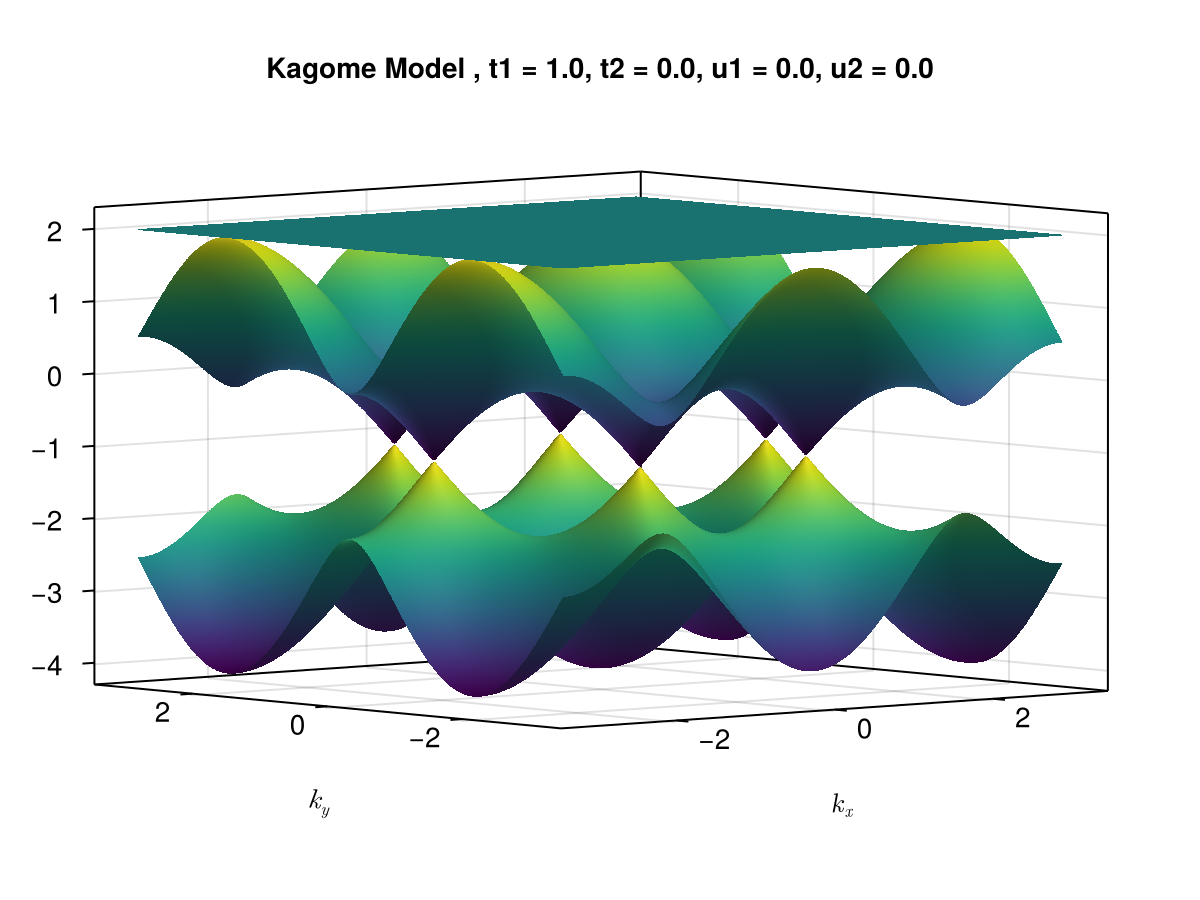

CairoMakie.Screen{IMAGE}


In [6]:
plot_bands3D_Kagome(t1 = 1.0, t2 = 0.0, u1 = 0.0, u2 = 0.0)

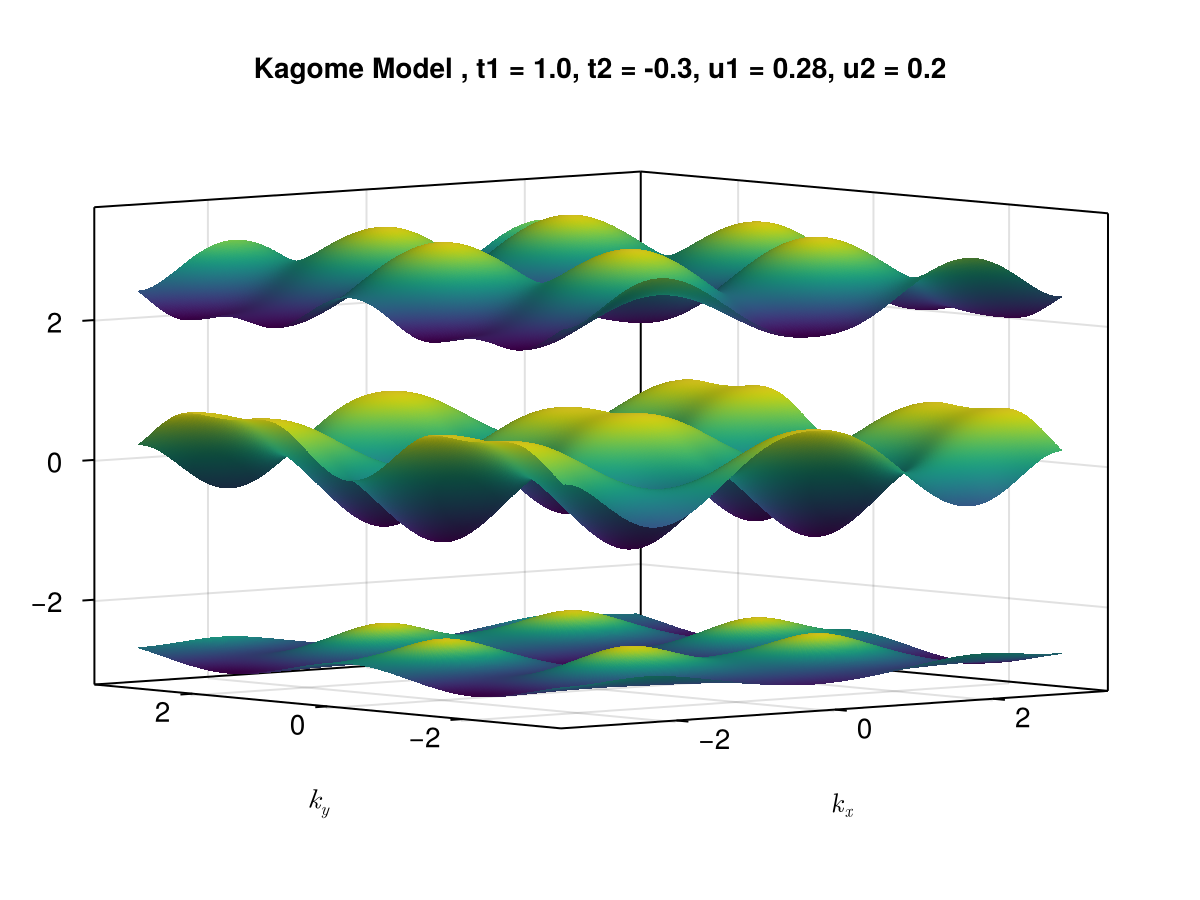

CairoMakie.Screen{IMAGE}


In [7]:
plot_bands3D_Kagome(t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2)

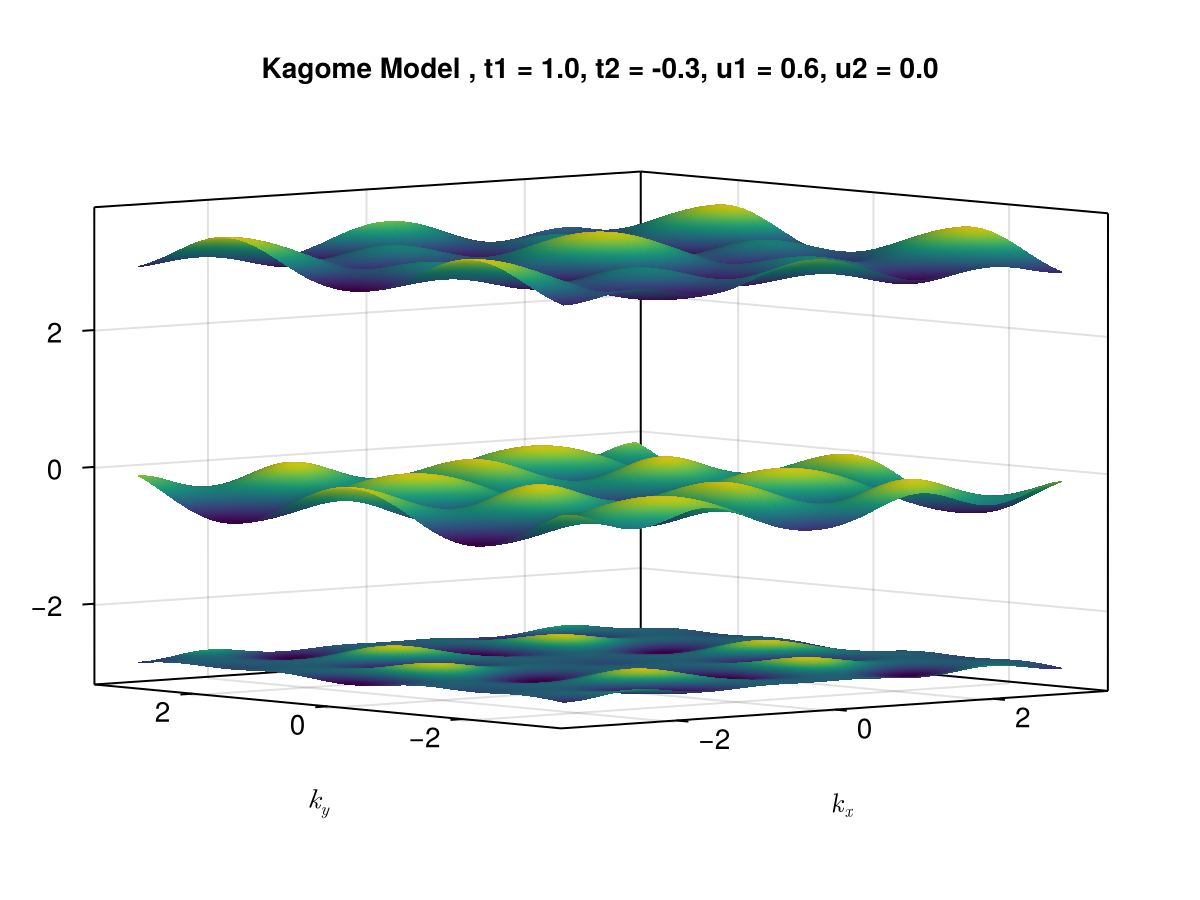

CairoMakie.Screen{IMAGE}


In [8]:
plot_bands3D_Kagome(t1 = 1.0, t2 = -0.3, u1 = 0.6, u2 = 0.0)

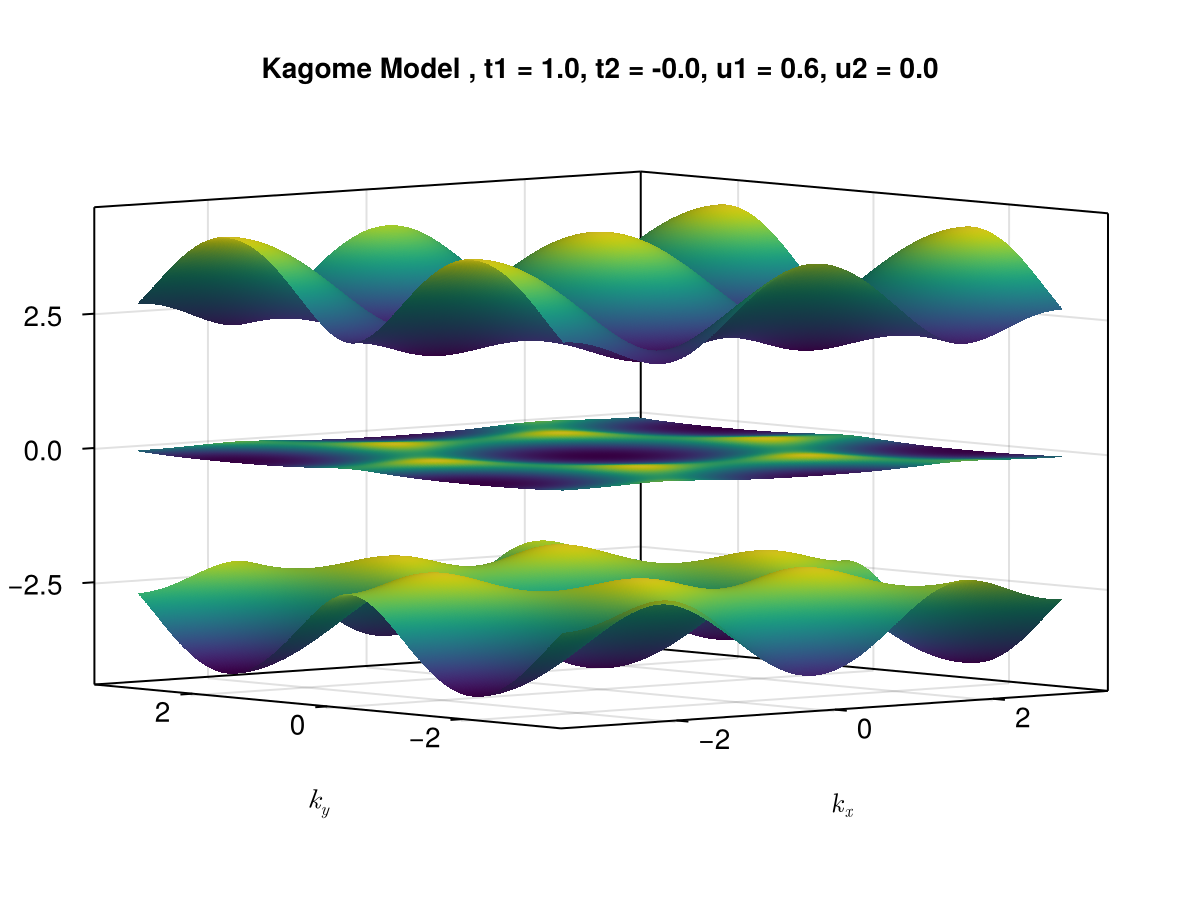

CairoMakie.Screen{IMAGE}


In [9]:
plot_bands3D_Kagome(t1 = 1.0, t2 = -0.0, u1 = 0.6, u2 = 0.0)

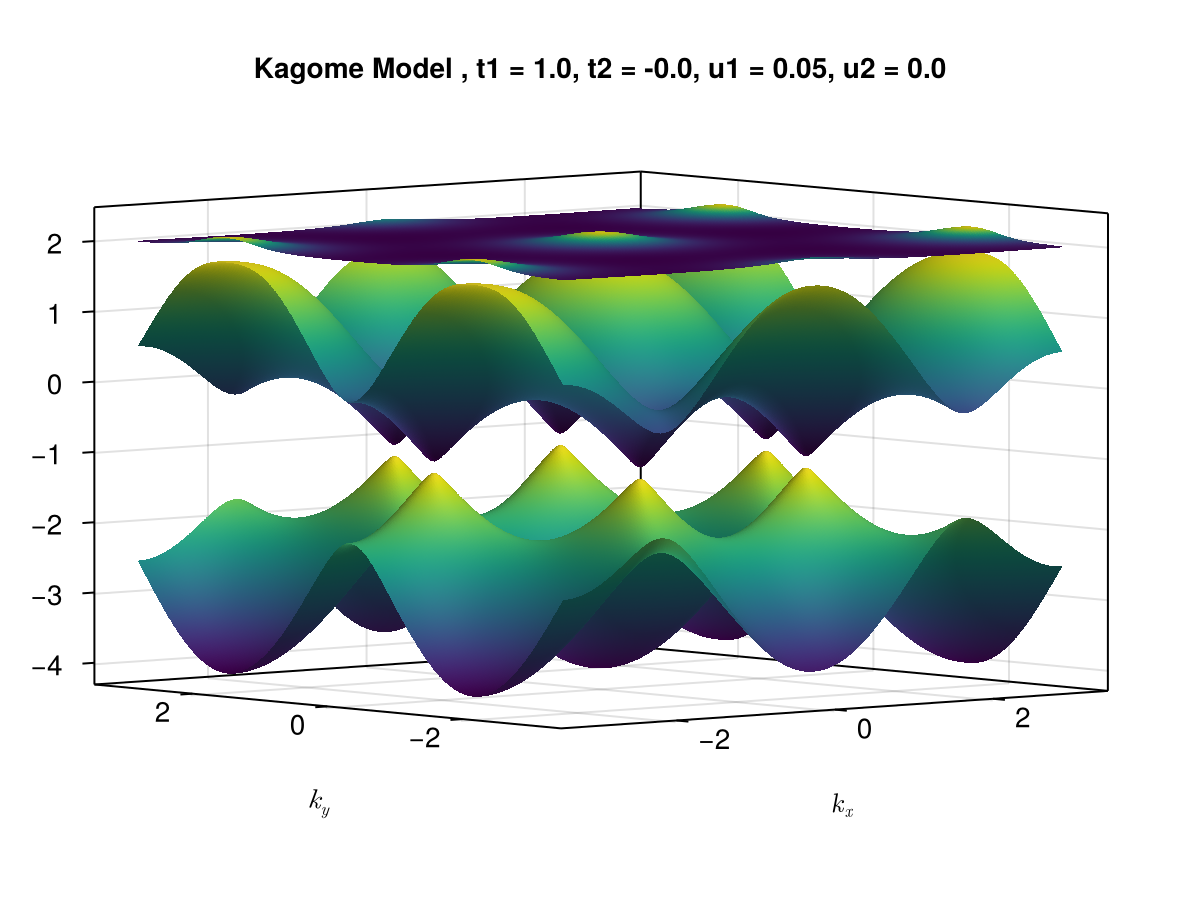

CairoMakie.Screen{IMAGE}


In [10]:
plot_bands3D_Kagome(t1 = 1.0, t2 = -0.0, u1 = 0.05, u2 = 0.0)

## Wilson Loop and Chern Number Calculations ##

In [11]:
function red_to_cart(recbasis, rvec)
    recbasis' * rvec
end
function get_line_fixed_k2(k2::Float64, nps::Int64, G::Matrix{Float64})
    lr::Vector{Vector{Float64}} = [[k1, k2] for k1 ∈ LinRange(0.0, 1.0, nps)]
    red_to_cart.(Ref(G), lr)
end
function get_line_fixed_k1(k1::Float64, nps::Int64, G::Matrix{Float64})
    lr::Vector{Vector{Float64}} = [[k1, k2] for k2 ∈ LinRange(0.0, 1.0, nps)]
    red_to_cart.(Ref(G), lr)
end

@inline function Wilson_Loop_fixed_ycycle(ps_ky::Vector{Vector{Float64}}, t1::Float64, t2::Float64, u1::Float64, u2::Float64, band::Int, nps::Int = 1000)
    """
    This is similar to the Wilson loop computation in the SSH model, 
    I think it is possible to work out a connection between the two models (Dimensional reduction ?)
    """
    spectrum = eigensystem_kagome.(ps_ky, Ref(t1), Ref(t2), Ref(u1), Ref(u2))

    # get eigenmodes 
    U_grid     = map(x -> x.vectors, spectrum)
    U_band     = map(x -> x[:, band], U_grid)
    # so far, we have the eigenmodes of the band at all points of the momentum space grid
    res::Complex{Float64} = 1.0 + 0.0 * im
    for n ∈ 1 : nps
        res *= U_band[n]' * U_band[mod1(n + 1, nps)]
    end
    angle(res)
end


@inline function Berry_Phase_Along_xcycle(;t1::Float64, t2::Float64, u1::Float64, u2::Float64, band::Int = 1, nps::Int = 1000, G::Matrix{Float64} = G)
    """
    Compute the Berry phase along the x cycle -- Goal is to calculate its monodromy
    """
    ps_k1 = LinRange(0.0, 1.0, nps)
    phase_vals = Vector{Float64}(undef, nps)
    for (n, k1) ∈ enumerate(ps_k1)
        kps = get_line_fixed_k1(k1, nps, G)
        phase_vals[n] = Wilson_Loop_fixed_ycycle(kps, t1, t2, u1, u2, band, nps)
    end
    phase_vals
end

function unwrap(phis)
    """
    Note that we are interested in the phase of a complex number. There's a 2π ambiguity. 
    So, we are free to shift the result by 2π. 
    So, if chern number C = 1, the Φ phase shifts by Φ -> Φ + 1 as 
    we move from -π to π. If we use a gauge transformation such that Φ = 0 at -π, π, 
    we must have a singularity somewhere in the function. i.e. there is no smooth gauge transformations 
        that interpolate between different winding sectors 
    """
    phis_unwrapped = Float64[]
    push!(phis_unwrapped, phis[1])
    for i ∈ 2 : length(phis)
        Δ = phis[i] - phis[i - 1]
        if Δ > π
            Δ -= 2.0 * π
        elseif Δ < -π
            Δ += 2.0 * π 
        end
        push!(phis_unwrapped, phis_unwrapped[end] + Δ)
    end
    return phis_unwrapped
end

function Winding(fvals)
    fvals = unwrap(fvals)
    nvals = size(fvals, 1)
    res::Float64 = 0.0
    for n ∈ 1 : nvals - 1
        nnext = n + 1
        diff = fvals[nnext] - fvals[n]
        res += diff
    end
    res / 2π
end

Winding (generic function with 1 method)

In [12]:
c1_band_1 = Winding(Berry_Phase_Along_xcycle(t1 = 1.0, t2 = -0.3, u1 = 0.6, u2 = 0.0, band = 1))
println("Chern number for first band: ", c1_band_1)

Chern number for first band: 1.0000000000000007


In [13]:
c1_band_2 = Winding(Berry_Phase_Along_xcycle(t1 = 1.0, t2 = -0.3, u1 = 0.6, u2 = 0.0, band = 2))
println("Chern number for second band: ", c1_band_2)

Chern number for second band: -7.067899292141149e-17


In [14]:
c1_band_3 = Winding(Berry_Phase_Along_xcycle(t1 = 1.0, t2 = -0.3, u1 = 0.6, u2 = 0.0, band = 3))
println("Chern number for third band: ", c1_band_3)

Chern number for third band: -1.0


In [15]:
Winding(Berry_Phase_Along_xcycle(t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2))

1.0000000000000007

In [16]:
Winding(Berry_Phase_Along_xcycle(t1 = 1.0, t2 = -0.0, u1 = 0.6, u2 = 0.0))

1.0000000000000013

In [17]:
Winding(Berry_Phase_Along_xcycle(t1 = 1.0, t2 = -0.0, u1 = 0.05, u2 = 0.0))

0.9999999999999999

In [18]:
Winding(Berry_Phase_Along_xcycle(t1 = 1.0, t2 = -0.0, u1 = 0.0, u2 = 0.0))

0.0

## Chern Number Calculation from integrating the Berry curvature over the FBZ  ## 

### Velocity Matrices 

In [19]:
@variables Φ1nn Φ2nn Φ3nn
Φ1nn = cos(k1)
Φ2nn = cos(k2)
Φ3nn = cos(k3)
Φ1nnn = cos(k2 + k3)
Φ2nnn = cos(k3 - k1)
Φ3nnn = cos(k1 + k2)

# Symbolic Differentiation 
Dx = Differential(kx); Dy = Differential(ky);

dΦ1dkxnn = simplify(expand_derivatives(Dx(Φ1nn)))
dΦ1dkynn = simplify(expand_derivatives(Dy(Φ1nn)))

dΦ2dkxnn = simplify(expand_derivatives(Dx(Φ2nn)))
dΦ2dkynn = simplify(expand_derivatives(Dy(Φ2nn)))

dΦ3dkxnn = simplify(expand_derivatives(Dx(Φ3nn)))
dΦ3dkynn = simplify(expand_derivatives(Dy(Φ3nn)));

dΦ1dkxnnn = simplify(expand_derivatives(Dx(Φ1nnn)))
dΦ1dkynnn = simplify(expand_derivatives(Dy(Φ1nnn)))

dΦ2dkxnnn = simplify(expand_derivatives(Dx(Φ2nnn)))
dΦ2dkynnn = simplify(expand_derivatives(Dy(Φ2nnn)))

dΦ3dkxnnn = simplify(expand_derivatives(Dx(Φ3nnn)))
dΦ3dkynnn = simplify(expand_derivatives(Dy(Φ3nnn)));


println("dΦ1dkxnn = ", dΦ1dkxnn, "\n")
println("dΦ1dkynn = ", dΦ1dkynn, "\n")

println("dΦ2dkxnn = ", dΦ2dkxnn, "\n")
println("dΦ2dkynn = ", dΦ2dkynn, "\n")

println("dΦ3dkxnn = ", dΦ3dkxnn, "\n")
println("dΦ3dkynn = ", dΦ3dkynn, "\n")

print("\n")

println("dΦ1dkxnnn = ", dΦ1dkxnnn, "\n")
println("dΦ1dkynnn = ", dΦ1dkynnn, "\n")

println("dΦ2dkxnnn = ", dΦ2dkxnnn, "\n")
println("dΦ2dkynnn = ", dΦ2dkynnn, "\n")

println("dΦ3dkxnnn = ", dΦ3dkxnnn, "\n")
println("dΦ3dkynnn = ", dΦ3dkynnn, "\n")

dΦ1dkxnn = -sin(kx)

dΦ1dkynn = 0

dΦ2dkxnn = -0.5sin(0.5kx + 0.8660254037844386ky)

dΦ2dkynn = -0.8660254037844386sin(0.5kx + 0.8660254037844386ky)

dΦ3dkxnn = 0.5sin(-0.5kx + 0.8660254037844386ky)

dΦ3dkynn = -0.8660254037844386sin(-0.5kx + 0.8660254037844386ky)


dΦ1dkxnnn = 0

dΦ1dkynnn = -1.7320508075688772sin(1.7320508075688772ky)

dΦ2dkxnnn = 1.5sin(-1.5kx + 0.8660254037844386ky)

dΦ2dkynnn = -0.8660254037844386sin(-1.5kx + 0.8660254037844386ky)

dΦ3dkxnnn = -1.5sin(1.5kx + 0.8660254037844386ky)

dΦ3dkynnn = -0.8660254037844386sin(1.5kx + 0.8660254037844386ky)



In [20]:
@inline function Vx(k::Vector{Float64}, t1::Float64, t2::Float64, u1::Float64, u2::Float64)
    kx::Float64 = k[1]; ky::Float64 = k[2]
    dΦ1_dx::ComplexF64 = -2.0 * ((-t1 + im * u1) * sin(kx))
    dΦ2_dx::ComplexF64 = 2.0 * (-(-t1 - im * u1) * sin(0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 + im * u2) * 1.5 * sin(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    dΦ3_dx::ComplexF64 = 2.0 * (0.5 * (-t1 + im * u1) * sin(-0.5 * kx + 0.5 * sqrt(3.0) * ky) - 1.5 * (-t2 - im * u2) * sin(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    m::Matrix{ComplexF64} = dΦ1_dx * T1u + dΦ2_dx * T2u + dΦ3_dx * T3u
    m + m'
end

@inline function Vy(k::Vector{Float64}, t1::Float64, t2::Float64, u1::Float64, u2::Float64)
    kx::Float64 = k[1]; ky::Float64 = k[2]
    dΦ1_dy::ComplexF64 = -sqrt(3.0) * (-t2 + im * u2) * sin(sqrt(3.0) * ky)
    dΦ2_dy::ComplexF64 = sqrt(3.0) * (-(-t1 - im * u1) * sin(0.5 * kx + 0.5 * sqrt(3.0) * ky) - (-t2 + im * u2) * sin(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    dΦ3_dy::ComplexF64 = sqrt(3.0) * (-(-t1 + im * u1) * sin(-0.5 * kx + 0.5 * sqrt(3.0) * ky) - (-t2 - im * u2) * sin(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    m::Matrix{ComplexF64} = dΦ1_dy * T1u + dΦ2_dy * T2u + dΦ3_dy * T3u
    m + m'
end;




In [21]:
@inline function calculate_kgrid(; G::Matrix{Float64} = G, nps::Int = 400)
    """
    Calculate a regular grid in the FBZ 
    """
    G1::Vector{Float64} = G[1, :]; G2::Vector{Float64} = G[2, :]
    kgrid = Matrix{Vector{Float64}}(undef, nps, nps)
    for n ∈ 1 : nps
        for m ∈ 1 : nps
            kgrid[n, m] = ((n - 1) * G1 + (m - 1) * G2) / nps
        end
    end
    kgrid
end

@inline function Berry_Curvature(k::Vector{Float64},
    t1::Float64, 
    t2::Float64, 
    u1::Float64, 
    u2::Float64, 
    band::Int = 1)

    (E, U) = eigensystem_kagome(k, t1, t2, u1, u2)
    Vxb::Matrix{ComplexF64} = U' * Vx(k, t1, t2, u1, u2) * U
    Vyb::Matrix{ComplexF64} = U' * Vy(k, t1, t2, u1, u2) * U

    bck::Float64 = 0.0

    for n ∈ 1:3
        if (n != band)
            bck += 2.0 * imag(Vxb[band, n] * Vyb[n, band]) / (E[band] - E[n])^2
        end
    end
    return bck
end

@inline function Quantum_Metric_xy(k::Vector{Float64},
    t1::Float64, 
    t2::Float64, 
    u1::Float64, 
    u2::Float64, 
    band::Int = 1)

    (E, U) = eigensystem_kagome(k, t1, t2, u1, u2)
    Vxb::Matrix{ComplexF64} = U' * Vx(k, t1, t2, u1, u2) * U
    Vyb::Matrix{ComplexF64} = U' * Vy(k, t1, t2, u1, u2) * U

    bck::Float64 = 0.0

    for n ∈ 1:3
        if (n != band)
            bck += real(Vxb[band, n] * Vyb[n, band]) / (E[band] - E[n])^2
        end
    end
    return bck
end

@inline function Quantum_Metric_xx(k::Vector{Float64},
    t1::Float64, 
    t2::Float64, 
    u1::Float64, 
    u2::Float64, 
    band::Int = 1)

    (E, U) = eigensystem_kagome(k, t1, t2, u1, u2)
    Vxb::Matrix{ComplexF64} = U' * Vx(k, t1, t2, u1, u2) * U
    
    bck::Float64 = 0.0

    for n ∈ 1:3
        if (n != band)
            bck += real(Vxb[band, n] * Vxb[n, band]) / (E[band] - E[n])^2
        end
    end
    return bck
end

@inline function Quantum_Metric_yy(k::Vector{Float64},
    t1::Float64, 
    t2::Float64, 
    u1::Float64, 
    u2::Float64, 
    band::Int = 1)

    (E, U) = eigensystem_kagome(k, t1, t2, u1, u2)
    Vxb::Matrix{ComplexF64} = U' * Vy(k, t1, t2, u1, u2) * U
    
    bck::Float64 = 0.0

    for n ∈ 1:3
        if (n != band)
            bck += real(Vyb[band, n] * Vyb[n, band]) / (E[band] - E[n])^2
        end
    end
    return bck
end




function chern_berry_curvature(;t1::Float64, t2::Float64, u1::Float64, u2::Float64, band::Int = 1, nps::Int = 400, G::Matrix{Float64})
    # prefactor 
    nk::Float64 = 1.0 * nps^2 
    pref::Float64 = 1.0 / (nk * 2.0 * pi)
    # Grid 
    kgrid::Matrix{Vector{Float64}} = calculate_kgrid(G = G, nps = nps)

    # Calculate the berry curvature over the grid 
    bc_grid = Berry_Curvature.(kgrid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    chern = 0.0 
    for bcv ∈ bc_grid
        chern += bcv
    end
    return chern * pref * det(G)
end

chern_berry_curvature (generic function with 1 method)

In [22]:
chern_berry_curvature(;t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2, band = 1, nps = 1000, G = G)

1.2016807054034828

In [23]:
chern_berry_curvature(;t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2, band = 2, nps = 1000, G = G)

-0.2931494040557999

In [24]:
chern_berry_curvature(;t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2, band = 3, nps = 1000, G = G)

-0.9085313013476835

In [25]:
chern_berry_curvature(;t1 = 1.0, t2 = -0.0, u1 = 0.6, u2 = 0.0, nps = 1000, G = G)

1.1666666666667784

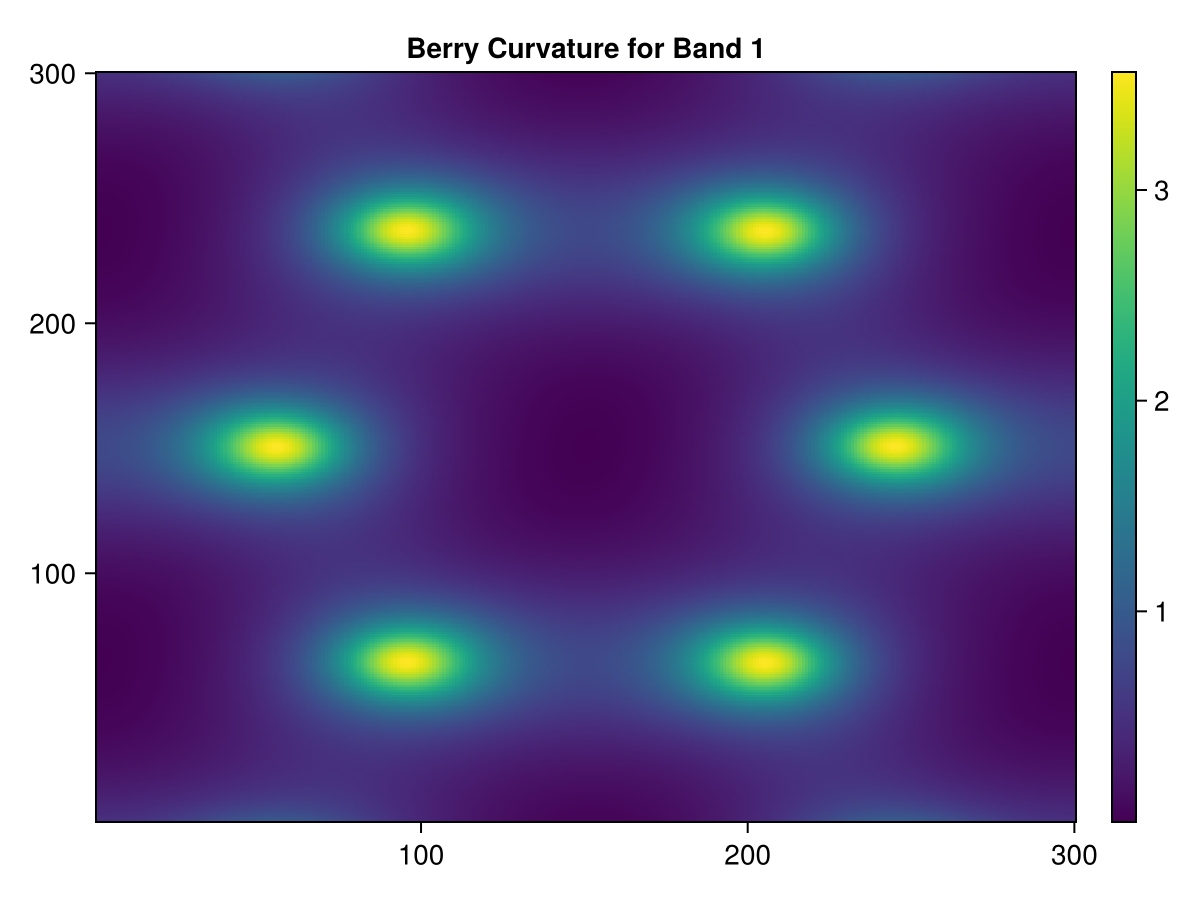

In [26]:
# Preliminary calculation of the Berry curvature 
let npts_perdim = 300, lim = 1.0, t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2, band = 1 
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end   
    
    bc_grid = Berry_Curvature.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))

    
    f = Figure()
    ax = Axis(f[1, 1], title="Berry Curvature for Band $band")
    m = heatmap!(ax, bc_grid, colormap=:viridis)
    Colorbar(f[1, 2], m)
    f
end


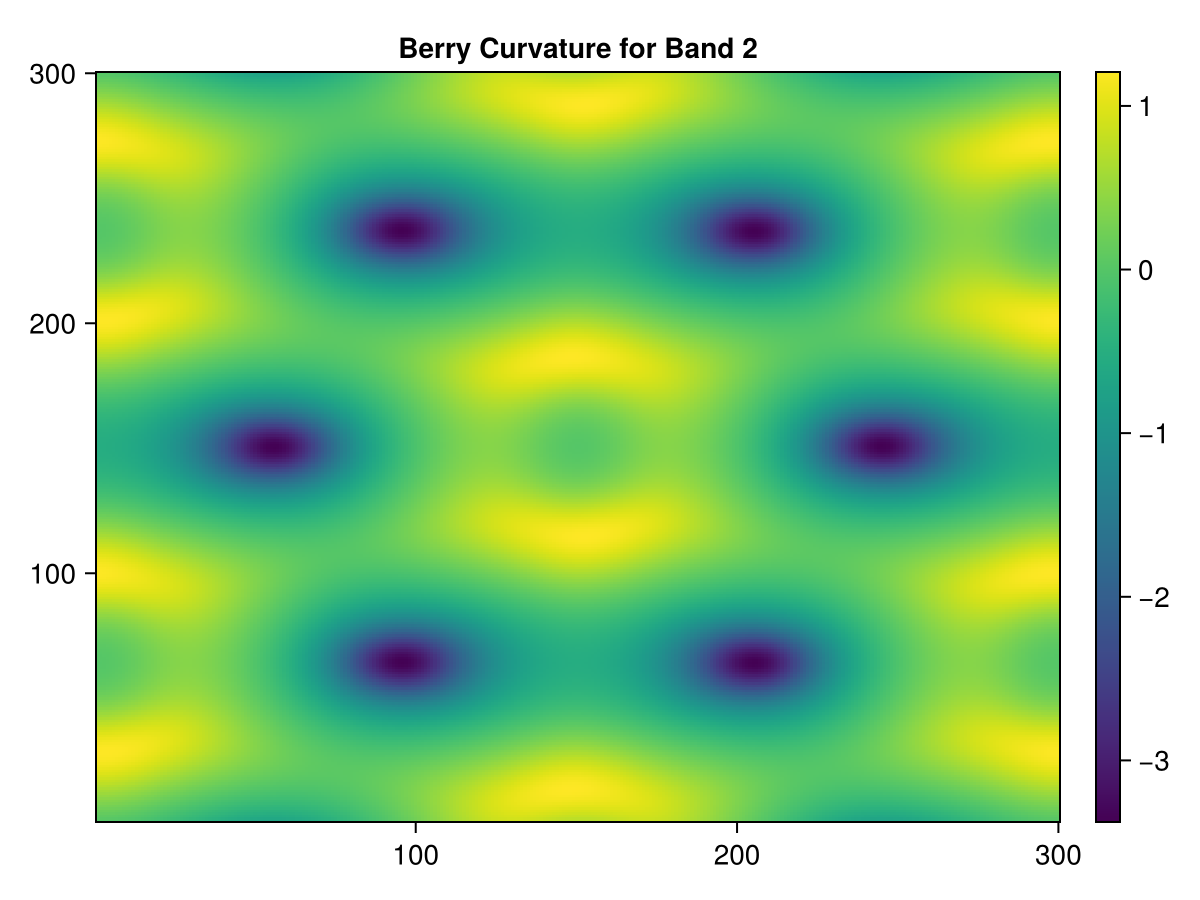

In [27]:
# Preliminary calculation of the Berry curvature 
let npts_perdim = 300, lim = 1.0, t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2, band = 2
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end   
    
    bc_grid = Berry_Curvature.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))

    
    f = Figure()
    ax = Axis(f[1, 1], title="Berry Curvature for Band $band")
    m = heatmap!(ax, bc_grid, colormap=:viridis)
    Colorbar(f[1, 2], m)
    f
end


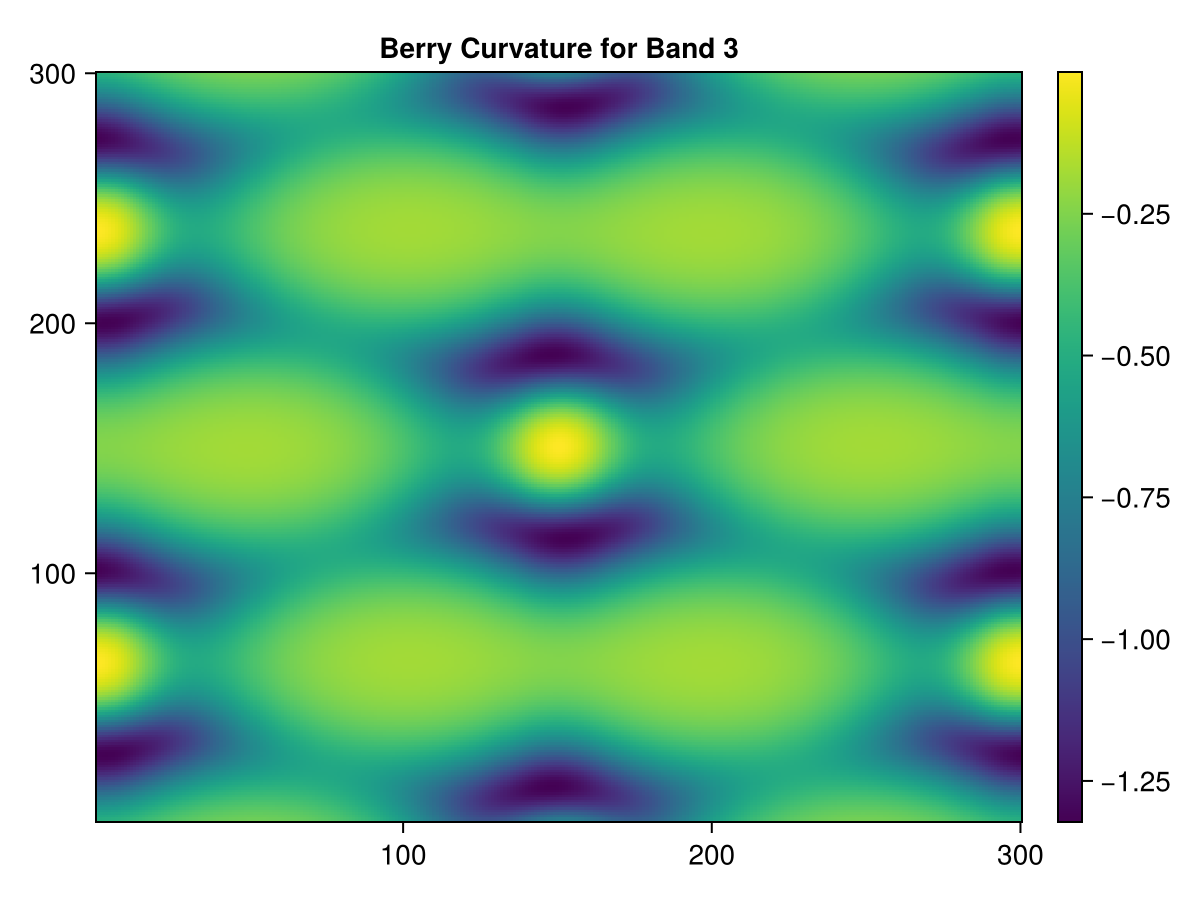

In [28]:
# Preliminary calculation of the Berry curvature 
let npts_perdim = 300, lim = 1.0, t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2, band = 3 
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end   
    
    bc_grid = Berry_Curvature.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))

    
    f = Figure()
    ax = Axis(f[1, 1], title="Berry Curvature for Band $band")
    m = heatmap!(ax, bc_grid, colormap=:viridis)
    Colorbar(f[1, 2], m)
    f
end


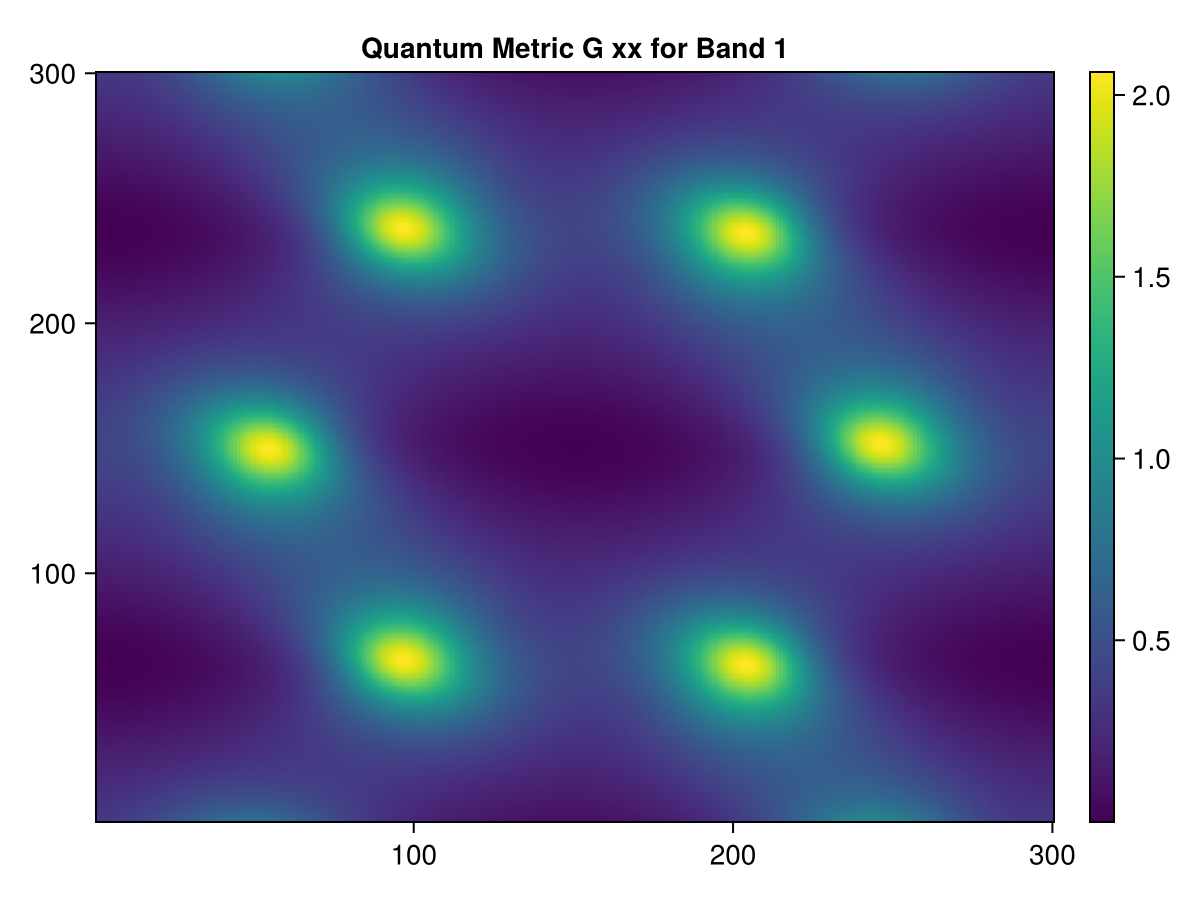

In [29]:
# Preliminary calculation of the Quantum Metric  
let npts_perdim = 300, lim = 1.0, t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2, band = 1, components = "xx"
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end   
    if components == "xx"
        bc_grid = Quantum_Metric_xx.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    elseif components == "xy"
        bc_grid = Quantum_Metric_xy.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    elseif components == "yy"
        bc_grid = Quantum_Metric_yy.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    end

    
    f = Figure()
    ax = Axis(f[1, 1], title="Quantum Metric G $components for Band $band")
    m = heatmap!(ax, bc_grid, colormap=:viridis)
    Colorbar(f[1, 2], m)
    f
end


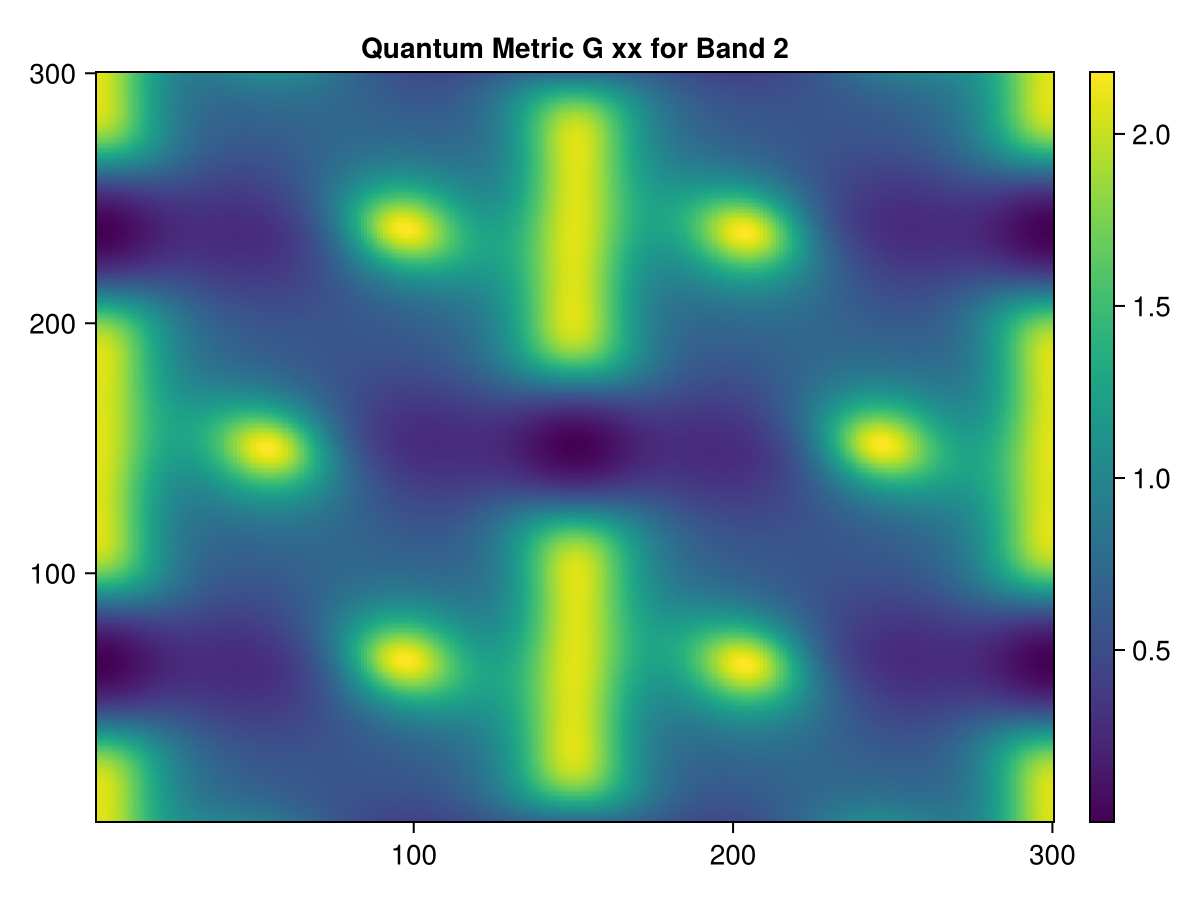

In [30]:
# Preliminary calculation of the Quantum Metric  
let npts_perdim = 300, lim = 1.0, t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2, band = 2, components = "xx"
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end   
    if components == "xx"
        bc_grid = Quantum_Metric_xx.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    elseif components == "xy"
        bc_grid = Quantum_Metric_xy.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    elseif components == "yy"
        bc_grid = Quantum_Metric_yy.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    end

    
    f = Figure()
    ax = Axis(f[1, 1], title="Quantum Metric G $components for Band $band")
    m = heatmap!(ax, bc_grid, colormap=:viridis)
    Colorbar(f[1, 2], m)
    f
end


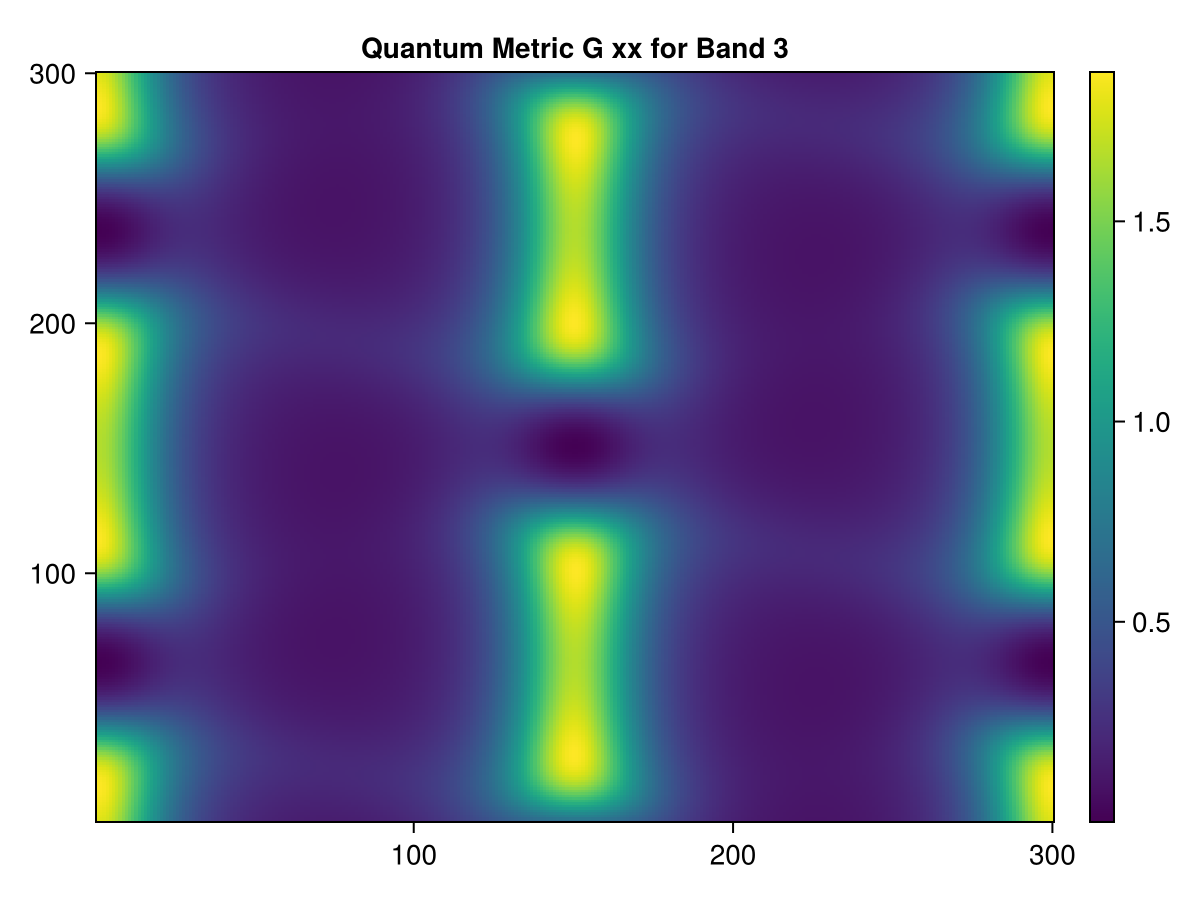

In [31]:
# Preliminary calculation of the Quantum Metric  
let npts_perdim = 300, lim = 1.0, t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2, band = 3, components = "xx"
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end   
    if components == "xx"
        bc_grid = Quantum_Metric_xx.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    elseif components == "xy"
        bc_grid = Quantum_Metric_xy.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    elseif components == "yy"
        bc_grid = Quantum_Metric_yy.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    end

    
    f = Figure()
    ax = Axis(f[1, 1], title="Quantum Metric G $components for Band $band")
    m = heatmap!(ax, bc_grid, colormap=:viridis)
    Colorbar(f[1, 2], m)
    f
end


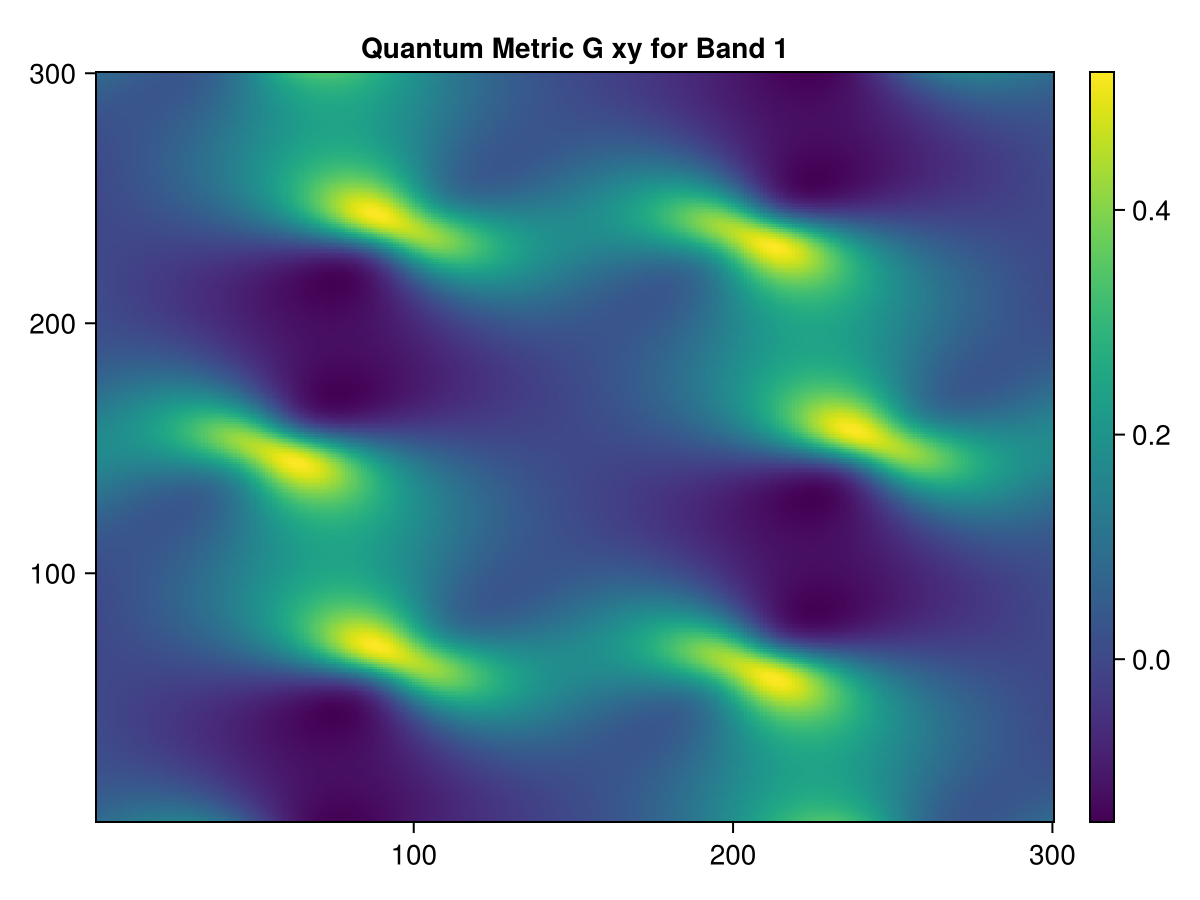

In [32]:
# Preliminary calculation of the Quantum Metric  
let npts_perdim = 300, lim = 1.0, t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2, band = 1, components = "xy"
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end   
    if components == "xx"
        bc_grid = Quantum_Metric_xx.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    elseif components == "xy"
        bc_grid = Quantum_Metric_xy.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    elseif components == "yy"
        bc_grid = Quantum_Metric_yy.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    end

    
    f = Figure()
    ax = Axis(f[1, 1], title="Quantum Metric G $components for Band $band")
    m = heatmap!(ax, bc_grid, colormap=:viridis)
    Colorbar(f[1, 2], m)
    f
end


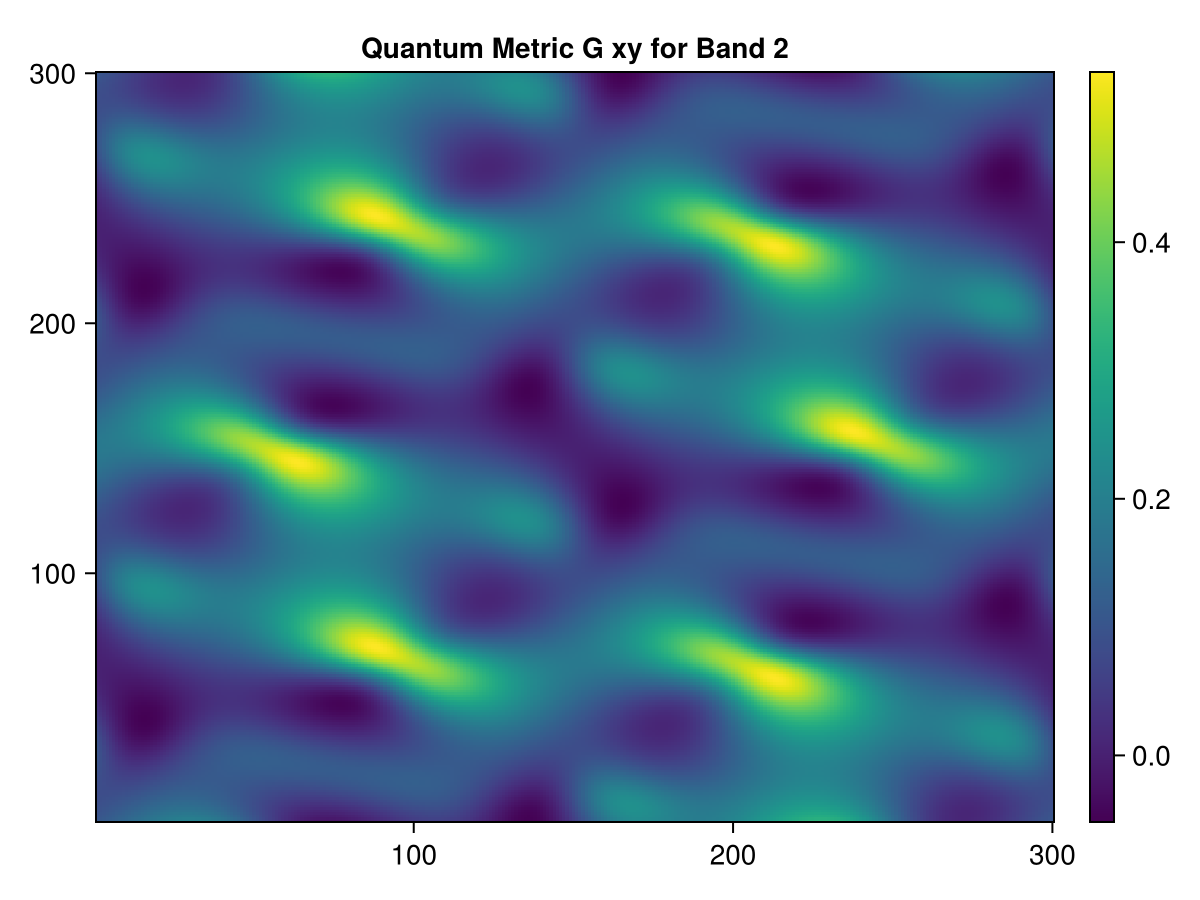

In [33]:
# Preliminary calculation of the Quantum Metric  
let npts_perdim = 300, lim = 1.0, t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2, band = 2, components = "xy"
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end   
    if components == "xx"
        bc_grid = Quantum_Metric_xx.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    elseif components == "xy"
        bc_grid = Quantum_Metric_xy.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    elseif components == "yy"
        bc_grid = Quantum_Metric_yy.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    end

    
    f = Figure()
    ax = Axis(f[1, 1], title="Quantum Metric G $components for Band $band")
    m = heatmap!(ax, bc_grid, colormap=:viridis)
    Colorbar(f[1, 2], m)
    f
end


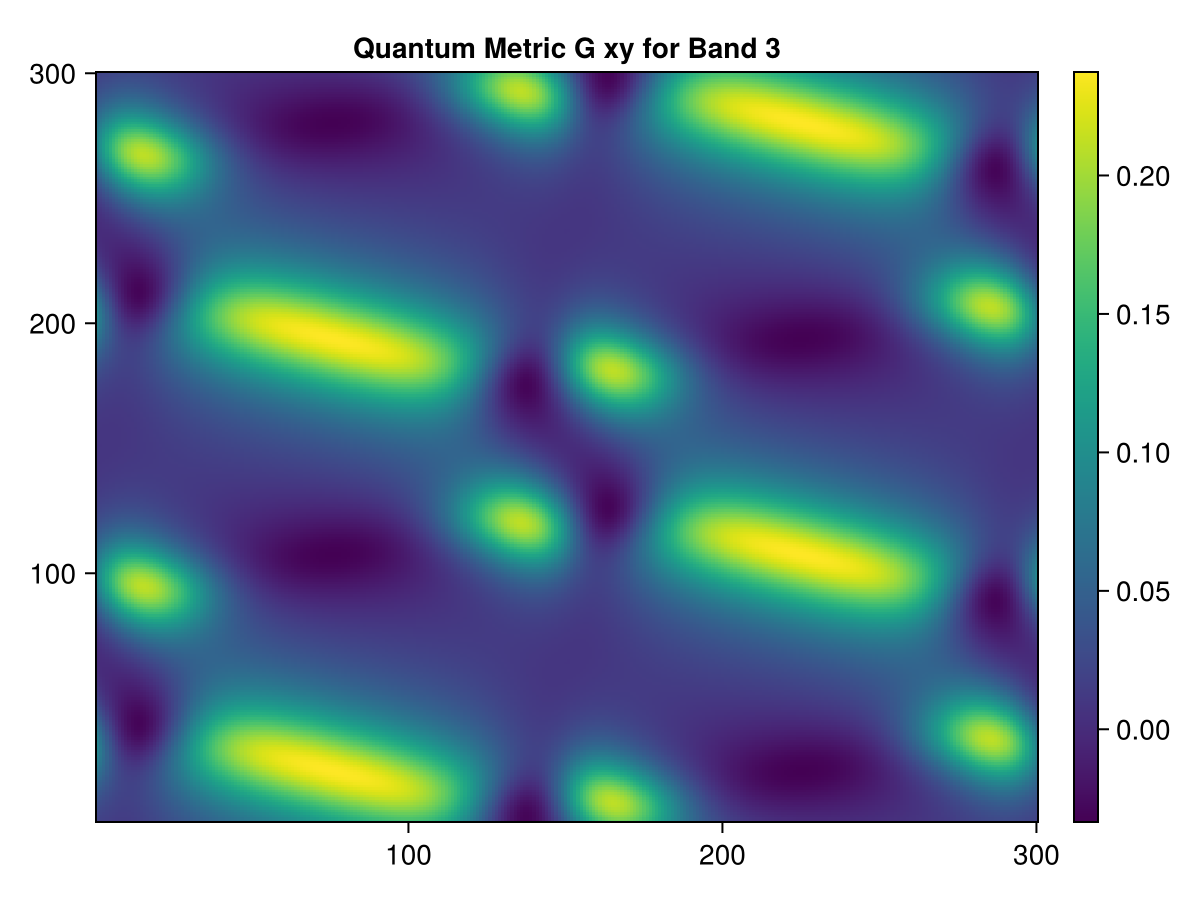

In [34]:
# Preliminary calculation of the Quantum Metric  
let npts_perdim = 300, lim = 1.0, t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2, band = 3, components = "xy"
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end   
    if components == "xx"
        bc_grid = Quantum_Metric_xx.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    elseif components == "xy"
        bc_grid = Quantum_Metric_xy.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    elseif components == "yy"
        bc_grid = Quantum_Metric_yy.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    end

    
    f = Figure()
    ax = Axis(f[1, 1], title="Quantum Metric G $components for Band $band")
    m = heatmap!(ax, bc_grid, colormap=:viridis)
    Colorbar(f[1, 2], m)
    f
end


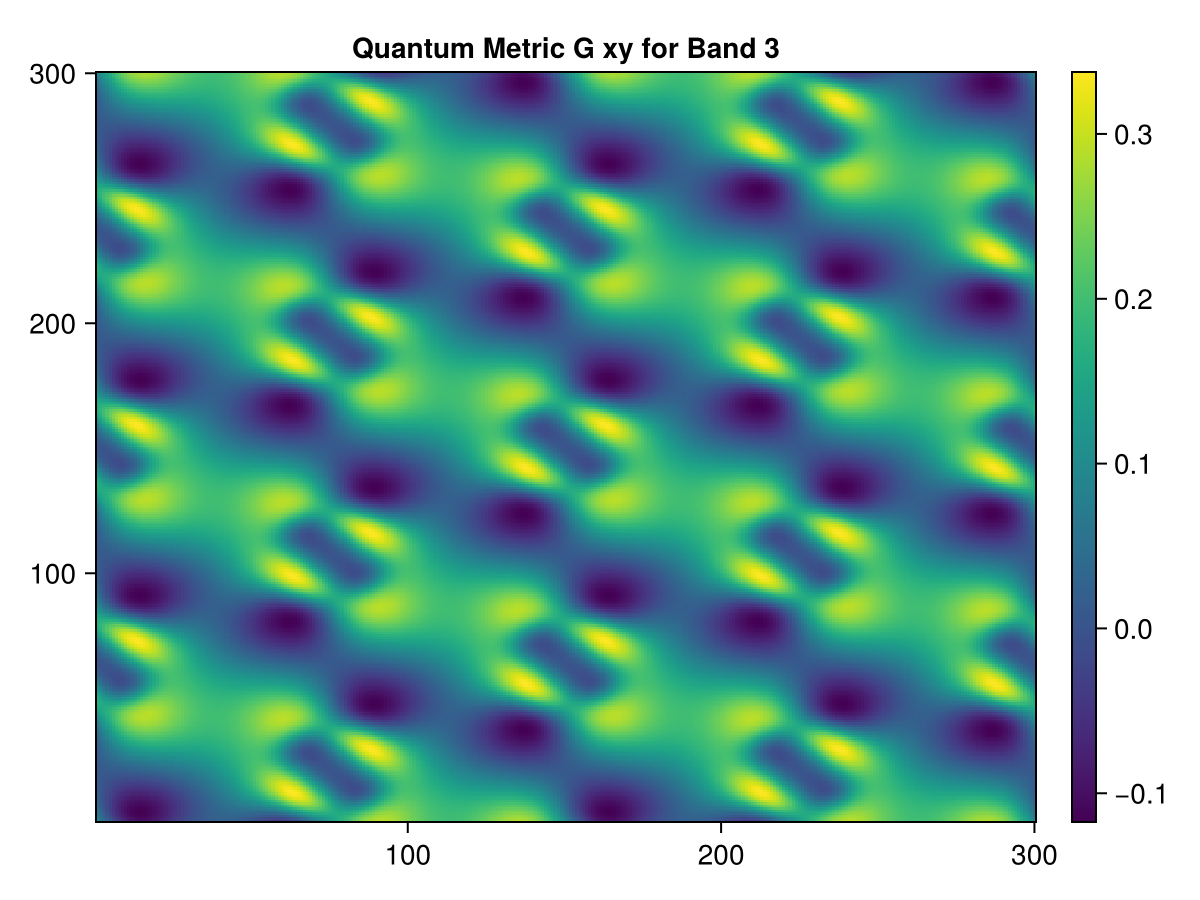

In [39]:
# Preliminary calculation of the Quantum Metric  
let npts_perdim = 300, lim = 2.0, t1 = 1.0, t2 = -0.0, u1 = 0.1, u2 = 0.0, band = 3, components = "xy"
    # construction of the grid 
    rng = LinRange(-lim * pi, lim * pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end   
    if components == "xx"
        bc_grid = Quantum_Metric_xx.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    elseif components == "xy"
        bc_grid = Quantum_Metric_xy.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    elseif components == "yy"
        bc_grid = Quantum_Metric_yy.(grid, Ref(t1), Ref(t2), Ref(u1), Ref(u2), Ref(band))
    end

    
    f = Figure()
    ax = Axis(f[1, 1], title="Quantum Metric G $components for Band $band")
    m = heatmap!(ax, bc_grid, colormap=:viridis)
    Colorbar(f[1, 2], m)
    f
end
